# **비디오게임 추천 시스템 구현**
---


## **프로젝트 Summary**
---

> **프로젝트명**

```
▶ 비디오게임 추천 시스템 구현
```  

> **프로젝트유형**

```
▶ 추천 시스템 구현 (※ Collaborative filtering)

```



## **문제상황 Introduction**
---


> **문제정의**

```
▶ 보다 더 개인화된 추천 시스템을 제공하고자 함
```  

> **기대효과**

```
▶ 유저 취향에 맞는 게임을 추천하여 게임 시장에서 높은 위치 확보, 선호도에 맞는 게임 개발 가능
```

> **해결방안**

```
▶ 사용자 기반의 추천 시스템을 구현하여 비슷한 사용자에 대하여 게임을 추천받을 수 있음
```


> **데이터 살펴보기**


|Column|Description|
|:---|:---|
|UserID|유저 아이디|
|Game|게임 타이틀|
|Action|구매/플레이|
|Hours|플레이시간|
|Other|기타|

* Hours : Hours if behavior is play, 1.0 if behavior is purchase





In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/개인 프로젝트/8')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/개인 프로젝트/8'

In [ ]:
import pandas as pd
df = pd.read_csv('P_PJT08_DATA.csv')
df.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


## Process01
---
DATA 전처리 및 EDA

### DATA 전처리
---

In [ ]:
df.shape

(200000, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  200000 non-null  int64  
 1   Game    200000 non-null  object 
 2   Action  200000 non-null  object 
 3   Hours   200000 non-null  float64
 4   Other   200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [ ]:
df.isnull().sum()

UserID    0
Game      0
Action    0
Hours     0
Other     0
dtype: int64

In [ ]:
df.describe()

,UserID,Hours,Other
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


### DATA EDA
---

In [ ]:
df.head()

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [ ]:
df.UserID.nunique()

12393

In [ ]:
df.Game.nunique()

5155

In [ ]:
df1 = df[df['Action']=='play'].copy()
df2 = df1.sort_values(['UserID', 'Hours'], ascending=False).drop_duplicates('UserID')
df2 = df2.sort_values('Hours', ascending=False)
df2.head()

,UserID,Game,Action,Hours,Other
123726,73017395,Sid Meier's Civilization V,play,11754.0,0
112643,100630947,Dota 2,play,10442.0,0
187005,153382649,Team Fortress 2,play,9640.0,0
165596,130882834,Dota 2,play,7765.0,0
183461,52567955,Dota 2,play,6964.0,0


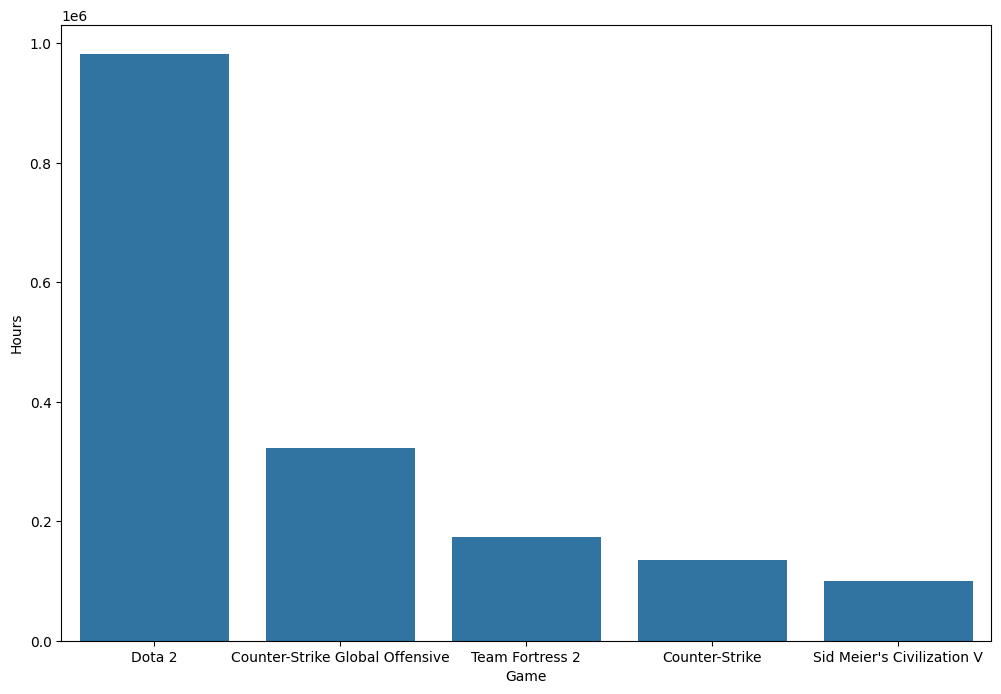

In [ ]:
# 플레이시간 top5 게임
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.barplot(df1.groupby('Game').Hours.sum().reset_index().sort_values('Hours', ascending=False).head(), x='Game', y='Hours')
plt.show()

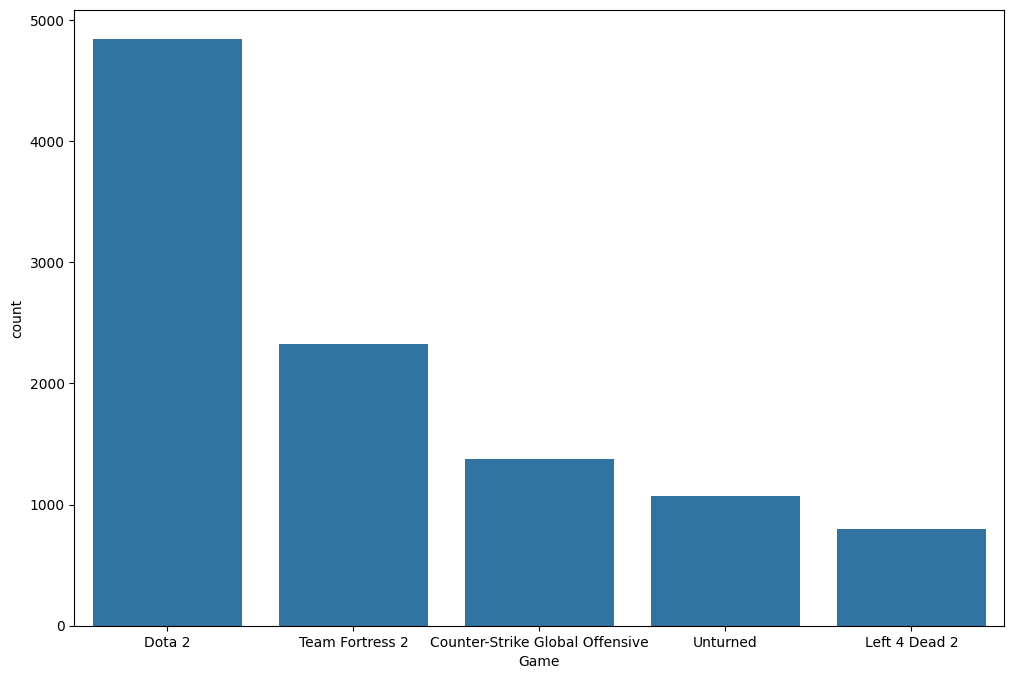

In [ ]:
# 플레이 유저 top5 게임
plt.figure(figsize=(12,8))
sns.barplot(df1.groupby('Game').Action.count().reset_index().sort_values('Action', ascending=False).head(), x='Game', y='Action')
plt.ylabel('count')
plt.show()

## Process02
---
비슷한 유저 가져오기

### Matrix 만들기

In [ ]:
df2 = pd.pivot_table(data=df1, index= 'UserID', columns='Game', values='Hours')
df2 = df2.fillna(0).sort_values('UserID')
df2.head()

Game,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
UserID,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df2.shape

(11350, 3600)

In [ ]:
print(df1.UserID.nunique())
print(df1.Game.nunique())

11350
3600


### 비슷한 유저 선정

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import operator
def similar_users(UserID, matrix, k=10):

    # 유저 정보 가져오기
    user = matrix[matrix.index == UserID]

    # 다른 유저 정보 가져오기
    other_users = matrix[matrix.index != UserID]

    # 해당 유저, 다른 유저 코사인 유사도 계산하기
    similarities = cosine_similarity(user,other_users)[0].tolist()

    # 다른 유저의 아이디로 리스트 만들기
    other_users_list = other_users.index.tolist()

    # 다른 유저 아이디 별 유사도 사전 만들기
    user_similarity = dict(zip(other_users_list, similarities))

    # 사전 정렬 / 사전 내 값을 아이템 객체로 변환, 유사도를 기준으로 정렬
    user_similarity_sorted = sorted(user_similarity.items(), key=operator.itemgetter(1))
    user_similarity_sorted.reverse()

    # 가장 높은 유사도의 다른 유저 k개 정렬하기
    top_users_similarities = user_similarity_sorted[:k]
    users = [i[0] for i in top_users_similarities]

    return users
    # 현재 유저에 대한 정보 찾기
    user = matrix[matrix.index == UserID]

In [ ]:
# 함수 적용하여 유저 id 입력 시 비슷한 유저 10명 추출
input_user_id =151603712

similar_users_list = similar_users(input_user_id, df2)
print(similar_users_list)

[124059151, 92436417, 58761868, 95037089, 98624963, 306690580, 302606492, 302341431, 297821985, 294091752]


## Process03
---
추천 게임목록 가져오기

### 비슷한 유저 기반으로 게임 추천

In [ ]:
# 비슷한 유저가 플레이한 게임 중 해당 유저가 플레이하지 않은 게임 가져오기
# 게임선정 기준: 시간

def recommend_game(user_index, similar_user_indices, matrix, gk=10):

    # 유저와 비슷한 유저 가져오기
    similar_users_l = matrix[matrix.index.isin(similar_user_indices)]

    # 비슷한 유저 게임 별로 평균 플레이 시간 계산하기
    similar_users_mean = similar_users_l.mean()

    # dataframe 변환
    similar_users_df = pd.DataFrame(similar_users_mean, columns=['play_time'])

    # 유저 아이디로 유저 플레이 정보 가져오기
    user_playtime = matrix.loc[user_index]

    # 현재 유저가 플레이하지 않은 게임 리스트 추출
    unplayed_games = user_playtime[user_playtime == 0].index.tolist()

    # 비슷한 유저들의 게임 플레이 시간으로 정렬
    similar_users_df_sort = similar_users_df.loc[unplayed_games].sort_values(by='play_time', ascending=False)

    # 상위 게임수(gk)만큼 추천 게임 선택
    top_n_games = similar_users_df_sort.head(gk)

    # 추천 게임 이름 가져오기
    recommended_content = top_n_games.index.tolist()

    return recommended_content

In [ ]:
# 비슷한 유저들의 플레이시간 평균을 이용하여 게임 10개 추천
recommend_game = recommend_game(input_user_id, similar_users_list, df2, gk=10)

print("-- 추천 게임 TOP 10 --")
print(recommend_game)

-- 콘텐츠 추천 TOP 10 --
['Borderlands 2', 'Call of Duty Modern Warfare 2', 'Middle-earth Shadow of Mordor', 'Call of Duty 4 Modern Warfare', 'Anno 2070', 'Toy Soldiers', 'DC Universe Online', 'Star Trek Online', 'Endless Space', 'Risen 2 - Dark Waters']
